# Worksheet 6: Hypothesis Testing

###  Lecture and Tutorial Learning Goals
After completing this week's lecture and tutorial work, you will be able to:

1. Give an example of a question you could answer with a hypothesis test.
2. Differentiate composite vs. simple hypotheses.
3. Given an inferential question, formulate null and alternative hypotheses to be used in a hypothesis test.
4. Identify the steps and components of a basic hypothesis test ("there is only one hypothesis test").
5. Write computer scripts to perform hypothesis testing via simulation, randomization and bootstrapping approaches, as well as interpret the output.
6. Describe the relationship between confidence intervals and hypothesis testing.
7. Discuss the potential limitations of this simulation approach to hypothesis testing.

In [1]:
# Run this cell before continuing.
library(cowplot)
library(digest)
library(gridExtra)
library(infer)
library(repr)
library(tidyverse)
library(datateachr)
source("tests_worksheet_06.R")


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Warning message:
“package ‘infer’ was built under R version 4.0.2”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks 

## 1. Short Recap & Warm-Up Question

The hypothesis testing problem is very similar to the confidence intervals problem you learned in Week 4.  There is just a shift in focus. For confidence intervals, we want to find plausible values for the parameter given a sample. In hypothesis testing, we want to find  "plausible" values for a statistic given a fixed value for the parameter. For example,  given a sample average $\bar{x}=2$, confidence intervals aim to find plausible values for the populational mean $\mu$. On the other hand, hypothesis tests assume a population parameter, say $\mu=2$, and aims to check if the obtained $\bar{x}$ is "compatible" with that value.

Before we start, let us refresh our memory on confidence intervals.

**Question 1.1**
<br>{points: 1}

When calculating a confidence interval, we are looking to find plausible values for a:

A. statistic;

B. parameter;

C. observations in the sample;

D. observations in the population;

_Assign your answer to an object called `answer1.1`. Your response should be a single character surrounded by quotes._

In [2]:
# answer1.1 <- ...

### BEGIN SOLUTION
answer1.1 <- "B"
### END SOLUTION

answer1.1

[1] "B"

In [3]:
test_1.1()

[1] "Success!"


**Question 1.2**
<br>{points: 1}

Consider the population of all UBC students in a given year. We want the proportion of students that have at least one car. 

Complete the sentences below using one of the following two options:

- `A` for constant
- `B` for random

--------------------

Before we take a sample:

1. The elements of the sample are ...
2. The sample proportion is ...
3. The sample standard error is ...
4. The boundaries of a confidence interval are ...
5. The parameter $p$ is ...

After we take the sample:
1. The elements of the sample are ...
2. The sample proportion is ...
3. The sample standard error is ...
4. The boundaries of a confidence interval are ...
5. The parameter $p$ is ...
6. The elements of bootstrap samples are ...



Your answer should be a string containing the letters associated with the terms in the same order as the sentences they complete. For example, one potential solution is "AAABBAAABB".

_Assign your answer to an object called `answer1.2`._

In [4]:
# answer1.2 <- ...

### BEGIN SOLUTION
answer1.2 <- "BBBBAAAAAAB"
### END SOLUTION

answer1.2

[1] "BBBBAAAAAAB"

In [5]:
test_1.2()

[1] "Success!"


## 2. Introduction to Hypothesis Testing

To introduce the idea of hypothesis testing, let us consider the Hepatitis C Virus (HCV) dataset. HCV is a virus that damages the liver. The HCV dataset contains several measurements obtained from blood tests at different stages of the disease, which are, in increasing order of severity: (1) No-Fibrosis; (2) Fibrosis; and (3) Cirrhosis. Let us take a look at the dataset first:

In [6]:
hcv_dataset <-
    read_csv("data/hcv-data-set.csv") %>% 
    mutate(category = fct_recode(category, "No-Fibrosis" = "Hepatitis")) %>% 
    filter(category != "Blood Donor") %>% 
    mutate(category = fct_drop(category))

head(hcv_dataset)

Parsed with column specification:
cols(
  category = col_character(),
  age = col_double(),
  sex = col_character(),
  albumin = col_double(),
  alkaline_phosphatase = col_double(),
  alanine_aminotransferase = col_double(),
  `
aspartate_aminotransferase` = col_double(),
  bilirubin = col_double(),
  `
cholinesterase` = col_double(),
  `
cholesterol` = col_double(),
  creatinine = col_double(),
  gamma_glutamyl_transferase = col_double(),
  PROT = col_double()
)



category,age,sex,albumin,alkaline_phosphatase,alanine_aminotransferase,aspartate_aminotransferase,bilirubin,cholinesterase,cholesterol,creatinine,gamma_glutamyl_transferase,PROT
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No-Fibrosis,38,m,45,56.3,NA,33.1,7,9.58,6.00,77.9,18.9,63.0
No-Fibrosis,19,m,41,NA,87.0,67.0,12,7.55,3.90,62.0,65.0,75.0
No-Fibrosis,23,m,47,19.1,38.9,164.2,17,7.09,3.20,79.3,90.4,70.1
No-Fibrosis,25,m,42,38.2,63.3,187.7,14,6.00,4.28,66.9,40.2,70.5
No-Fibrosis,27,m,45,27.5,10.5,37.8,10,8.77,3.20,55.2,35.9,74.5
No-Fibrosis,29,m,49,NA,53.0,39.0,15,8.79,3.60,79.0,37.0,90.0


Albumin is a protein produced by the liver. Since Hepatitis C causes liver damage, one might suspect that people with hepatitis C would have lower albumin levels than healthy people. Although this is quite reasonable, is there enough evidence to support this claim? The difference in albumin levels might be so big (or so small) that we could easily answer this question with a simple plot. In other cases, however, the answer is not entirely clear. 

The medical community has established that the average level of albumin in people with a healthy liver is `44g/L`.
In the next exercise, you will start investigating the level of albumin in patients carrying HCV. 

**Question 2.1**
<br>{points: 1}

Plot the boxplots of the `albumin` level for each stage of the disease by filling in the scaffolding below. Let us also add a line to represent the level of albumin in people with a healthy liver.

_Assign your plot to an object called `boxplots`._

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”


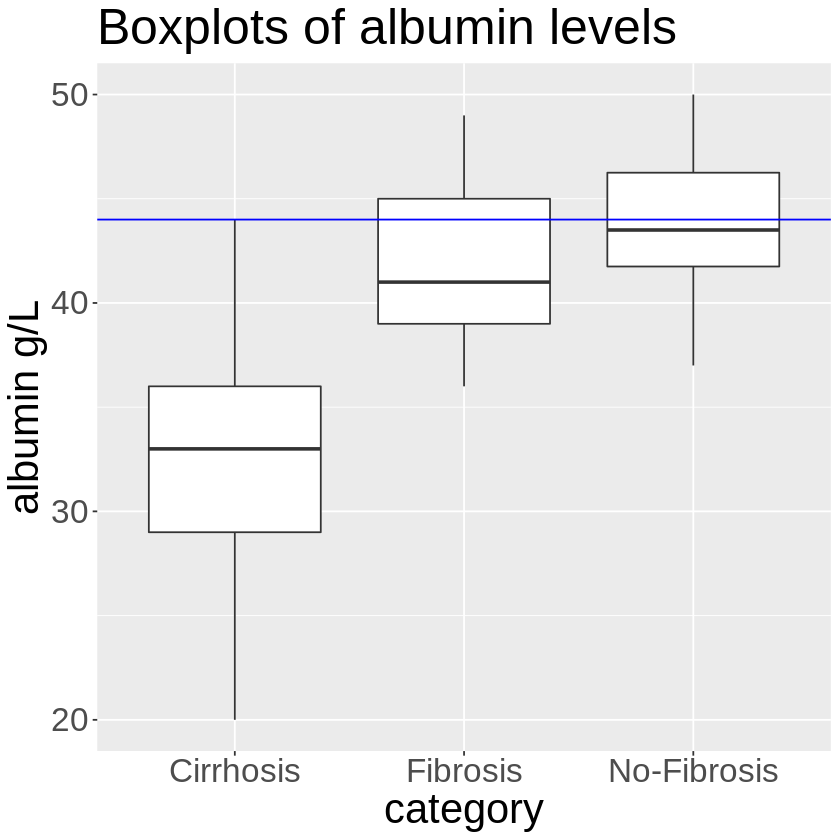

In [7]:
#boxplots <- 
#    ... %>%  
#    ggplot(aes(x = ..., y = albumin)) + 
#    geom_...() + 
#    ylab("albumin g/L") +
#    ...(...) +
#    theme(text = element_text(size=25)) +
#    geom_hline(yintercept=..., color="blue")

### BEGIN SOLUTION
boxplots <- 
    hcv_dataset %>%  
    ggplot(aes(x = category, y = albumin)) + 
    geom_boxplot() + 
    ylab("albumin g/L") +
    ggtitle("Boxplots of albumin levels") +
    theme(text = element_text(size=25)) +
    geom_hline(yintercept=44, color="blue")
### END SOLUTION
boxplots

In [8]:
test_2.1()

[1] "Success!"


**Question 2.2**
<br>{points: 1}

Compare the boxplots of albumin levels in each group against the mean albumin level of people with healthy livers. Then, for each category, please select the statement you think is most suitable. 

Statements: 

a. The boxplot shows a sample distribution that is not compatible with a mean level of albumin of 44g/L. In other words, it would be very surprising (or unlucky!) to obtain such a sample distribution from a population with a mean level of albumin of 44g/L.

b. The boxplot shows a sample distribution that is compatible with a mean level of albumin of 44g/L. 

c. The boxplot shows some indications that the sample does not come from a population with a mean albumin level of 44g/L. However, it is hard to tell if the distinction is due to the sampling variability or a real difference in the mean albumin level.

_Assign the letter of the statement `"a"`, `"b"`, or `"c"`, for each of the groups in object `answer2.2`._

In [9]:
answer2.2 <- NULL
#answer2.2['No-Fibrosis'] <- 
#answer2.2['Fibrosis'] <- 
#answer2.2['Cirrhosis'] <- 

### BEGIN SOLUTION
answer2.2['No-Fibrosis'] <- "b"
answer2.2['Fibrosis'] <- "c"
answer2.2['Cirrhosis'] <- "a"
### END SOLUTION

answer2.2

No-Fibrosis    Fibrosis   Cirrhosis 
        "b"         "c"         "a"

In [10]:
test_2.2()

[1] "Success!"


Note that we are not trying to find the plausible values for the true mean of the albumin level for each category based on our sample (which would be a confidence interval). Instead, we are trying to see if the sample we have is compatible with a hypothetical scenario of interest: the categories have the same mean level of albumin as people with a healthy liver. In other words, would it be plausible to obtain the sample we got if the hypothetical scenario of interest was real? 

Hypothesis testing is like a counter-proof. We are not trying to prove that a hypothetical scenario is real. We are checking if there is enough evidence in our sample to contradict the hypothesis (i.e., our sample is "too incompatible" with such a hypothetical scenario).

But what is a hypothesis precisely? A hypothesis is a statement about the population. Some examples of hypotheses:

1. The population is normally distributed.
2. The populational mean, $\mu$, is equal to a specified value $\mu_0$.
3. The populational proportion, $p$, is higher than a specified value of $p_0$. 

Although a hypothesis can be more general (like Example 1 above), hypotheses frequently refer to a population parameter such as mean, proportion, or variance. A hypothesis testing consists of two competing hypotheses: (1) $H_0$, the _null hypothesis_; and (2) $H_A$ (or $H_1$), the alternative hypothesis. The null hypothesis is generally the status quo, i.e., the hypothesis that no change has happened. It is assumed that $H_0$ and $H_A$ cover all the possible scenarios. (this means that either $H_0$ or $H_A$ is true -- but we do not know which). 

**Question 2.3**
<br>{points: 1}

In HCV dataset, we are investigating if the liver damage caused by the Hepatitis C Virus will reduce the albumin level compared to people with a healthy liver. What is the _null hypothesis_ we are testing?

A. $H_0: \mu<44g/L$

B. $H_0: \mu=44g/L$

C. $H_0: \mu>44g/L$

D. $H_0: \mu\neq44g/L$


_Assign your answer to an object called `answer2.3`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"`._

In [11]:
#answer2.3 <- 

### BEGIN SOLUTION
answer2.3 <- "B"
### END SOLUTION

answer2.3

[1] "B"

In [12]:
test_2.3()

[1] "Success!"


**Question 2.4**
<br>{points: 1}

In HCV dataset, we are investigating if the liver damage caused by the Hepatitis C Virus will reduce the albumin level compared to people with a healthy liver. What is the _alternative hypothesis_?

A. $H_A: \mu<44g/L$

B. $H_A: \mu=44g/L$

C. $H_A: \mu>44g/L$

D. $H_A: \mu\neq44g/L$


_Assign your answer to an object called `answer2.4`. Your answer should be one of `"A"`, `"B"`, `"C"`, or `"D"`._

In [13]:
#answer2.4 <- 

### BEGIN SOLUTION
answer2.4 <- "A"
### END SOLUTION

answer2.4

[1] "A"

In [14]:
test_2.4()

[1] "Success!"


Now that you have your _null hypothesis_ and _alternative hypothesis_ defined, it is time to conduct the hypothesis test, i.e., to check if there is enough evidence in your data to say that the _null hypothesis_ is false. But first, we need to understand what is meant by "enough evidence".  

**Question 2.5**
<br>{points: 3}

For now, assume that the `hcv_dataset` contains the entire population of patients with `Fibrosis`. Your job is to do three things: 

A. Fill in the code below to get the mean albumin level of patients with `Fibrosis`. 
_Assign the result to an object called `answer2.5_A`_.

B. Is the albumin level of patients with `Fibrosis` the same, lower, or higher than the albumin level of patients with healthy liver? _Assign the string "lower", "same", or "higher", to an object called `answer2.5_B`_.

C. True or false: we can conclude with absolute certainty, just based on the mean value obtained in `Item A`, that the mean albumin level of patients with `Fibrosis` is lower than that of patients with a healthy liver. _Assign "TRUE" or "FALSE" to an object called `answer2.5_C`_ 

In [15]:
#answer2.5_A <- 
#    hcv_dataset %>% 
#    filter(category == ...) %>% 
#    summarise(mean_albumin = ...)

#answer2.5_B <- ...
#answer2.5_C <- ...

### BEGIN SOLUTION
answer2.5_A <- 
    hcv_dataset %>% 
    filter(category == "Fibrosis") %>% 
    summarise(mean_albumin = mean(albumin))

answer2.5_B <- "lower"
answer2.5_C <- "true"
### END SOLUTION

answer2.5_A
answer2.5_B 
answer2.5_C

mean_albumin
<dbl>
41.7619


[1] "lower"

[1] "true"

In [16]:
test_2.5_A()

[1] "Success!"


In [17]:
test_2.5_B()

[1] "Success!"


In [18]:
test_2.5_C()

[1] "Success!"


However, contrary to the previous question's assumption, `hcv_dataset` does not contain the entire population of patients with `Fibrosis`. We do not have access to the entire population, so we cannot calculate the parameter of interest and compare it with the hypothesized value. The decision to reject or not reject $H_0$ will be based on a sample. The first thing we need to decide is the sample statistic that we will use to test the _null hypothesis_. This statistic is known as _test statistic_. 

**Question 2.6**
<br>{points: 3}

Considering the two hypotheses defined in Questions 2.3 and 2.4, which of the statistics below is adequate to be used as the test statistic?

A. the sample median $Q_2$.

B. the sample mean $\bar{x}$.

C. the sample standard deviation: $s=\sqrt{\frac{1}{n-1}\sum_{i=1}^n\left(x_i-\bar{x}\right)^2}$

D. the constant $\mu_0 = 44$

_Assign your answer to an object called `answer2.6`. Your answer should be a single character surrounded by quotes._

In [19]:
# answer2.6 <- ...

### BEGIN SOLUTION
answer2.6 <- "B"
### END SOLUTION

answer2.6

[1] "B"

In [20]:
test_2.6()

[1] "Success!"


**Question 2.7**
<br>{points: 3}

A difficulty that arises is that the test statistic is dependent on the sample. Different samples provide different values for the test statistic. Therefore, we cannot just compare the test statistic's value with the hypothesized value of 44 g/L of albumin.

In this exercise, you will obtain the bootstrapped sampling distribution of your test statistic using 10,000 replications. 

_Assign your answer to an object called `samp_dist_mean_albumin`._

In [21]:
set.seed(7) # Do not change this!

fibrosis <-                         
    hcv_dataset %>%                 
    filter(category == "Fibrosis") 

#samp_dist_mean_albumin <- 
#     fibrosis %>% 
#     specify(response = ...) %>% 
#     generate(type = ..., reps = ...) %>% 
#     calculate(stat = ...)


### BEGIN SOLUTION
samp_dist_mean_albumin <- 
     fibrosis %>% 
     specify(response = albumin) %>% 
     generate(type = "bootstrap", reps = 10000) %>% 
     calculate(stat = "mean")
### END SOLUTION

head(samp_dist_mean_albumin)

replicate,stat
<int>,<dbl>
1,42.14286
2,41.90476
3,42.95238
4,41.80952
5,40.76190
6,41.76190


In [22]:
test_2.7()

[1] "Success!"


**Question 2.8**
<br>{points: 1}

Fill in the code below to obtain the observed test statistic. 

_Assign your answer to an object named `obs_test_stat`_.

In [23]:
#obs_test_stat <- ...(fibrosis$albumin)

### BEGIN SOLUTION
obs_test_stat <- mean(fibrosis$albumin)
### END SOLUTION

obs_test_stat

[1] 41.7619

In [24]:
test_2.8()

[1] "Success!"


**Question 2.9**
<br>{points: 3}

Fill in the code below to plot the bootstrap sampling distribution you obtained in Question 2.7.

_Assign your answer to an object called `samp_dist_mean_albumin_plot`._

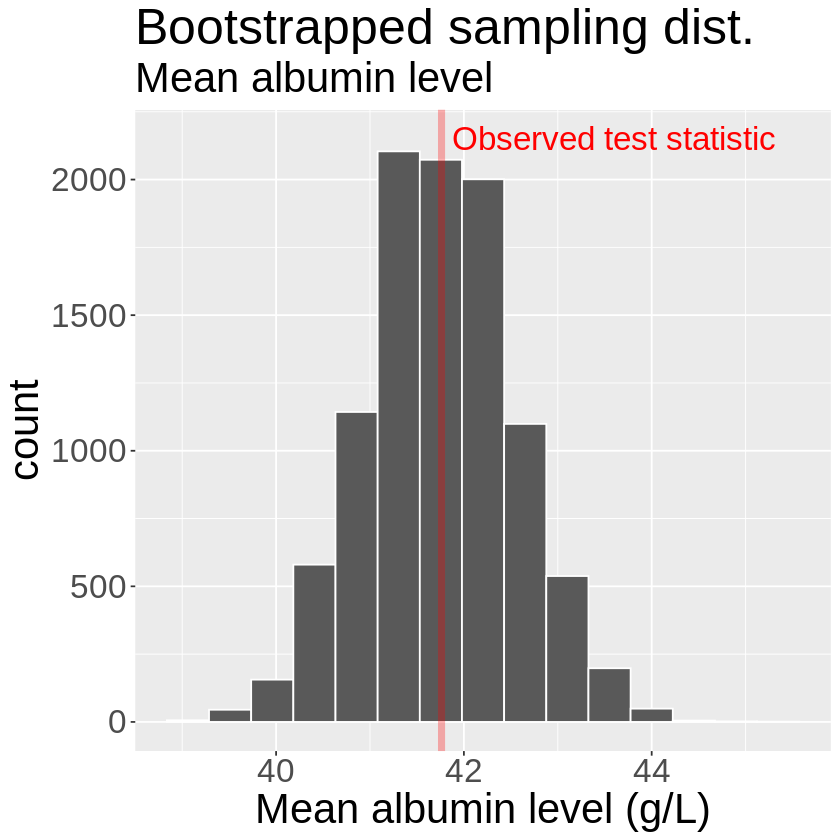

In [25]:
#samp_dist_mean_albumin_plot <- 
#     ... %>% 
#     ggplot() + 
#     geom_...(aes(..), bins = 15, color="white") +
#     geom_vline(xintercept = obs_test_stat, color = "red", alpha=.3, lwd=2) + 
#     xlab(...) + 
#     theme(text = element_text(size=25)) + 
#     ggtitle("Bootstrapped sampling dist.", subtitle = "Mean albumin level ") +
#     annotate("text", x = 43.6, y = 2150, label = "Observed test statistic", color="red", size=7)

### BEGIN SOLUTION
samp_dist_mean_albumin_plot <- 
     samp_dist_mean_albumin %>% 
     ggplot() + 
     geom_histogram(aes(stat), bins = 15, color="white") +
     geom_vline(xintercept = obs_test_stat, color = "red", alpha=.3, lwd=2) + 
     xlab("Mean albumin level (g/L)") + 
     theme(text = element_text(size=25)) + 
     ggtitle("Bootstrapped sampling dist.", subtitle = "Mean albumin level ") +
     annotate("text", x = 43.6, y = 2150, label = "Observed test statistic", color="red", size=7)
### END SOLUTION

samp_dist_mean_albumin_plot

In [26]:
test_2.9()

[1] "Success!"


**Question 2.10: the Null model**
<br>{points: 3}

The test statistic's sampling distribution under the _null hypothesis_ ($H_0$) is called _null model_ or _null distribution_. Up to now, you have been studying the sampling distribution of a statistic using bootstrap simulation. This time you will use bootstrap to examine how the sampling distribution of your test statistic would look like if $H_0$ were true. 

The _null hypothesis_ states that the population mean is 44 g/L, which implies that, under $H_0$, the mean of the test statistic's sampling distribution is 44 g/L. Your job here is to obtain the _null model_ by recentering the sampling distribution stored in `samp_dist_mean_albumin` to 44 g/L.

_Assign your answer to an object named `null_model`_.

In [27]:
#null_model <- 
    #samp_dist_mean_albumin %>% 
    #mutate(...)

### BEGIN SOLUTION
null_model <- 
    samp_dist_mean_albumin %>% 
    mutate(stat = stat + (44-obs_test_stat))
### END SOLUTION

head(null_model)

replicate,stat
<int>,<dbl>
1,44.38095
2,44.14286
3,45.19048
4,44.04762
5,43.00000
6,44.00000


In [28]:
test_2.10()

[1] "Success!"


**Question 2.11: the Null model**
<br>{points: 3}

Fill in the code below to plot the _null model_ you obtained in the previous question. Also, add a vertical line to the plot at the observed value of the test statistic. 

_Assign your answer to an object called `null_model_plot`_.

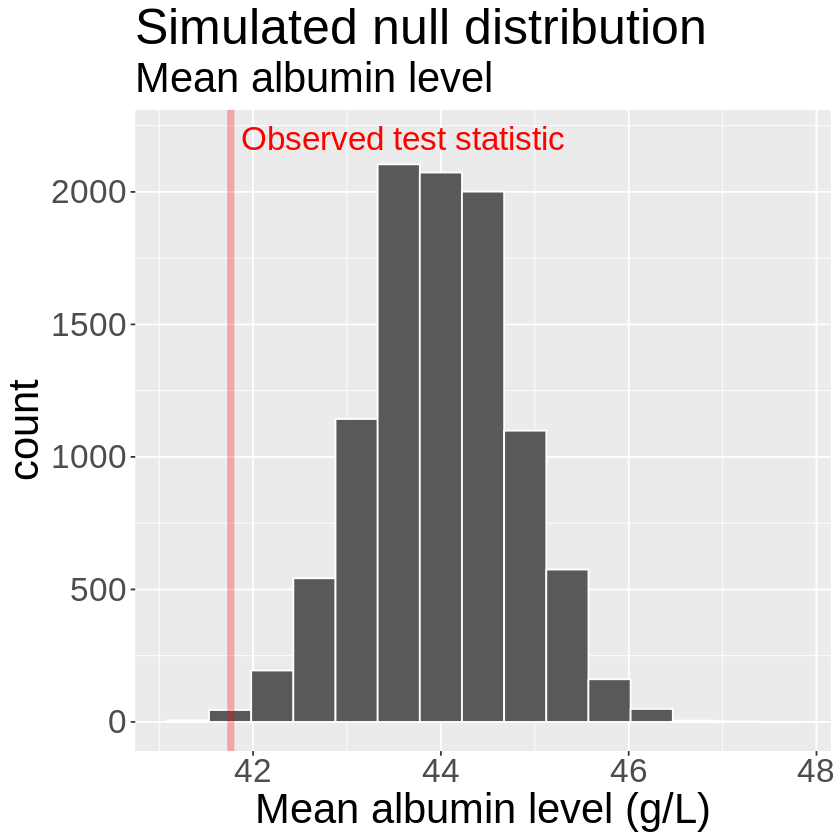

In [29]:
#null_model_plot <-
#     null_model %>% 
#     ggplot() +
#     geom_...(..., bins = 15, color="white") +
#     geom_vline(xintercept = obs_test_stat, color = "red", alpha=.3, lwd=2) + 
#     xlab("Mean albumin level (g/L)") + 
#     theme(text = element_text(size=25)) + 
#     ggtitle("Simulated null distribution", subtitle = "Mean albumin level") +
#     annotate("text", x = 43.6, y = 2200, label = "Observed test statistic", color="red", size=7)

### BEGIN SOLUTION
null_model_plot <-
     null_model %>% 
     ggplot() +
     geom_histogram(aes(stat), bins = 15, color="white") +
     geom_vline(xintercept = obs_test_stat, color = "red", alpha=.3, lwd=2) + 
     xlab("Mean albumin level (g/L)") + 
     theme(text = element_text(size=25)) + 
     ggtitle("Simulated null distribution", subtitle = "Mean albumin level ") +
     annotate("text", x = 43.6, y = 2200, label = "Observed test statistic", color="red", size=7)
### END SOLUTION

null_model_plot

In [30]:
test_2.11()

[1] "Success!"


**Question 2.12: p-value**
<br>{points: 3}

Is the observed value of the test statistic a plausible value to be obtained if $H_0$ were true? To answer this question, you will calculate the probability of getting a value more "extreme" than the observed test statistic under the null distribution. This probability is called _p-value_. 

_Assign your answer to an object called p_value_.

In [31]:
#p_value <- mean(null_model$stat < ...)

### BEGIN SOLUTION
p_value <- mean(null_model$stat < obs_test_stat)
### END SOLUTION

p_value

[1] 0.0017

In [32]:
test_2.12()

[1] "Success!"


**Question 2.13: Decision**
<br>{points: 3}

Based on the _p-value_ you got in the previous question, which of the following you think better describes the situation?

A. The low value of the p-value shows that it is entirely plausible to obtain the observed test statistic if $H_0$ were true. Therefore, $H_0$ should not be rejected.

B. The low value of the p-value shows that it is quite unlikely to get the observed test statistic if $H_0$ were true, which _certainly_ shows that $H_0$ is false. Therefore, $H_0$ should be rejected. 

C. The low value of the p-value shows that it is quite unlikely to get the observed test statistic if $H_0$ were true, which _suggests_ that $H_0$ is false. Therefore, $H_0$ should be rejected. 

D. The _p-value_ is quite low, and since the _p-value_ is the probability that $H_0$ is true, we should reject $H_0$. 

_Assign your answer to an object called `answer2.13`. Your answer should be a single character surrounded by quotes._

In [33]:
#answer2.13 <-

### BEGIN SOLUTION
answer2.13 <- "C"
### END SOLUTION

answer2.13

[1] "C"

In [34]:
test_2.13()

[1] "Success!"


**Question 2.14: Types of Error**
<br>{points: 3}

There are two possible errors we could make in hypothesis testing:

1. Type I Error: happens when we wrongly reject $H_0$ (i.e., we reject $H_0$ when $H_0$ is true);
2. Type II Error: happens when we wrongly do not reject $H_0$ (i.e., we do not reject $H_0$ when $H_0$ is False);
![](imgs/errors_table.png)

Considering the decision you made in Question 2.13, which type of error you are subject to commit? 

A. Type I Error

B. Type II Error

_Assign your answer to an object called `answer2.14`._

In [35]:
#answer2.14 <-

### BEGIN SOLUTION
answer2.14 <- "A"
### END SOLUTION

answer2.14

[1] "A"

In [36]:
test_2.14()

[1] "Success!"


**Question 2.15: Significance level**
<br>{points: 3}

We know that a low _p-value_ is evidence against $H_0$. But how low must the _p-value_ be for us to decide to reject $H_0$? 

When performing hypothesis testing, we must set the so-called _significance level_. The significance level, $\alpha$, is the probability of _Type I Error_. We will reject $H_0$ if the p-value is smaller than the significance level we chose. Typical values of $\alpha$ are $10\%, 5\%$, and $1\%$. It is important that you specify the $\alpha$ level before conducting the hypothesis testing and obtaining the p-value. 

For this question, you must select all the significance level below for which we would reject $H_0$:

A. $10\%$

B. $5\%$

C. $1\%$

D. $0.1\%$

E. None of the above.

Your answer should be a string containing the letters associated with the items you selected in the same order as the items appear. For example, if you want to select `B` and `D`, you should use `"BD"`,  not `"DB"`. 

_Assign your answer to an object called `answer2.15`._

In [37]:
#answer2.15 <- 

### BEGIN SOLUTION
answer2.15 <- "ABC"
### END SOLUTION

answer2.15

[1] "ABC"

In [38]:
test_2.15()

[1] "Success!"


**Question 2.16: hypothesis testing with the `infer` package**
<br>{points: 3}

The `infer` package has a similar [workflow to conduct hypothesis tests](https://moderndive.com/9-hypothesis-testing.html#ht-infer) to the one you have been using for confidence intervals. 

In this question, you will conduct the same hypothesis test you just did manually, but this time you are going to use the `infer` package. Fill in the code below to generate 10,000 bootstrap samples from the null model using the `infer` workflow. Then, try comparing the first ten rows of the model you manually generated `null_model` with the first ten rows you obtained using `infer`

_Assign your answer to an object called `null_model_infer`_. 

In [39]:
set.seed(7) # Do not change this.

#null_model_infer <- 
#    fibrosis %>% 
#    specify(...) %>% 
#    hypothesise(...) %>% 
#    generate(...) %>% 
#    calculate(...)

### BEGIN SOLUTION
null_model_infer <- 
    fibrosis %>% 
    specify(response = albumin) %>% 
    hypothesise(null = "point", mu = 44) %>% 
    generate(reps = 10000) %>% 
    calculate( stat = "mean")
### END SOLUTION

head(null_model_infer)

Setting `type = "bootstrap"` in `generate()`.



replicate,stat
<int>,<dbl>
1,44.38095
2,44.14286
3,45.19048
4,44.04762
5,43.00000
6,44.00000


In [40]:
test_2.16()

[1] "Success!"


**Question 2.17: Visualizing the result of the hypothesis test `infer`**
<br>{points: 3}


The `infer` package also makes it easy to visualize the result of your hypothesis test with `visualize` and `shade_p_value` functions (see [Section 9.3.1 of Modern Dive](https://moderndive.com/9-hypothesis-testing.html#ht-infer)).

Fill in the code below to visualize the result of your hypothesis test. 

_Assign the answer to an object named `null_model_vis_infer`_

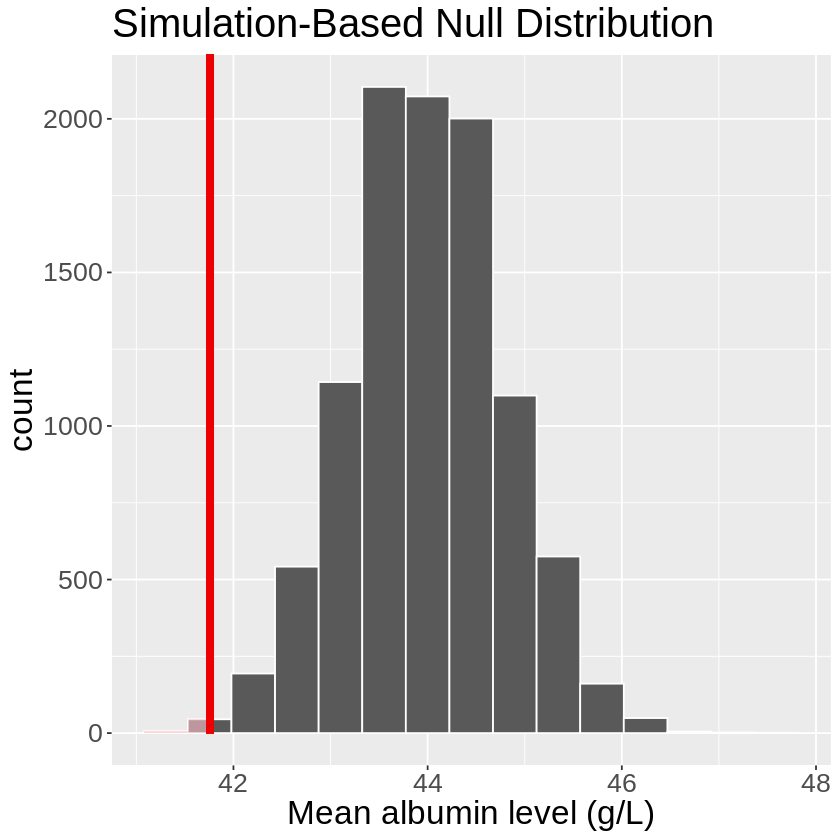

In [41]:
#null_model_vis_infer <-
#    null_model_infer %>% 
#    visualize(...) + 
#    shade_p_value(obs_stat = ..., direction = ...) +
#    xlab("Mean albumin level (g/L)") + 
#    theme(text = element_text(size=20))

### BEGIN SOLUTION
null_model_vis_infer <- 
    null_model_infer %>% 
    visualize() + 
    shade_p_value(obs_stat = obs_test_stat, direction = "left") +
    xlab("Mean albumin level (g/L)") + 
    theme(text = element_text(size=20))
### END SOLUTION

null_model_vis_infer

In [42]:
test_2.17()

[1] "Success!"


**Question 2.18: Getting the p-value with `infer`**
<br>{points: 1}

To get the p-value with the `infer` package, we use the `get_p_value` function. Obtain the p-value using the `null_model_infer`. 

_Assign your answer to p_value_infer_

In [43]:
#p_value_infer <- 
#    null_model_infer %>% 
#    get_p_value(...)

### BEGIN SOLUTION
p_value_infer <- 
    null_model_infer %>% 
    get_p_value(obs_stat = obs_test_stat, direction = "left")
### END SOLUTION

p_value_infer

p_value
<dbl>
0.0017


In [44]:
test_2.18()

[1] "Success!"


## 3. Hypothesis testing with two populations

In the previous section, the hypothesis involved only one parameter from one population: the mean level of albumin in patients with `Fibrosis`. 

In this section, you will work with two populations, and your hypothesis will involve a parameter from each population. Although it seems more complicated, fear not, the process is pretty much the same: 

1. Specify the variable of interest (`specify()`);
2. Define your hypotheses (`hypothesise()`);
3. Simulate the observations (`generate()`);
4. Generate values from the null model (`caculate()`);
5. See how the observed statistic compares with the sampling distribution by checking the p-value.

In the following sequence of exercises, we will try to answer the following question: 

> Is the diameter of the trees in Kitsilano bigger than in Kerrisdale?

**Question 3.1: What are we comparing exactly?**
<br>{points: 2}

Different trees will have different diameters. We need a summary quantity to summarise each population: (1) all the trees in Kitsilano; and (2) all the trees in Kerrisdale. Which of the following quantities are appropriate to help answer the question (select all that apply):

A. Population mean;

B. Population variance;

C. Population median;

D. Population mode; 

_Assign your answer to an object called `answer3.1`. Your response should be a sequence of characters, e.g., "ABCD"._

In [45]:
#answer3.1 <-

### BEGIN SOLUTION
answer3.1 <- "AC"
### END SOLUTION

answer3.1

[1] "AC"

In [46]:
test_3.1()

[1] "Success!"


**Question 3.2: Setting the hypothesis**
<br>{points: 2}

If we were to use the median, say $m_1$ is the median diameter of the trees in Kitsilano and $m_2$ the median diameter of the trees in Kerrisdale, what are the appropriate hypotheses?

A. $H_0: m_1-m_2 = 0$ vs $H_1: m_1-m_2 < 0$

B. $H_0: m_1-m_2 = 0$ vs $H_1: m_1-m_2 > 0$

C. $H_0: m_1-m_2 > 0$ vs $H_1: m_1-m_2 < 0$

D. $H_0: m_1-m_2 < 0$ vs $H_1: m_1-m_2 = 0$

_Assign your answer to an object called `answer3.2`._

In [47]:
#answer3.2 <-

### BEGIN SOLUTION
answer3.2 <- "B"
### END SOLUTION

answer3.2

[1] "B"

In [48]:
test_3.2()

[1] "Success!"


**Question 3.3: The truth!**
<br>{points: 3}

Let us assume that the entire population of trees in Kitsilano and Kerrisdale is stored in the `trees_pop` variable. Let's find out the truth! 
What is the median diameter of each population of trees? Fill in the code below to find out.

_Assign your answer to an object called `answer3.3`._

In [49]:
# Run this code before continuing
trees_pop <-
    vancouver_trees %>% 
    filter(neighbourhood_name %in% c("KITSILANO", "KERRISDALE")) %>% 
    select(neighbourhood_name, diameter)

head(trees_pop)

neighbourhood_name,diameter
<chr>,<dbl>
KITSILANO,10.0
KITSILANO,14.5
KERRISDALE,3.0
KITSILANO,3.0
KITSILANO,16.0
KITSILANO,30.0


In [50]:
#answer3.3 <- 
#    trees_pop %>% 
#    ...(neighbourhood_name) %>% 
#    ...(median = ...)

### BEGIN SOLUTION
answer3.3 <- 
    trees_pop %>% 
    group_by(neighbourhood_name) %>% 
    summarise(median = median(diameter))
### END SOLUTION

answer3.3

`summarise()` ungrouping output (override with `.groups` argument)



neighbourhood_name,median
<chr>,<dbl>
KERRISDALE,10
KITSILANO,12


In [51]:
test_3.3()

[1] "Success!"


**Question 3.4: Let's take a sample**
<br>{points: 3}

A sample of 31 trees from Kitsilano and 35 trees from Kerrisdale was taken and stored in the object `sample_trees`. Calculate the observed test statistic. 

_Assign your answer to an object called `obs_med_diam_diff`_

In [52]:
set.seed(12) # Do not change this

# Run this cell before continuing.
sample_trees <- 
    trees_pop %>% 
    filter(neighbourhood_name=="KERRISDALE") %>% 
    sample_n(size=35) %>% 
    bind_rows(
        trees_pop %>% 
            filter(neighbourhood_name=="KITSILANO") %>% 
            sample_n(size=31))

head(sample_trees)

neighbourhood_name,diameter
<chr>,<dbl>
KERRISDALE,8.00
KERRISDALE,21.75
KERRISDALE,16.50
KERRISDALE,16.00
KERRISDALE,3.00
KERRISDALE,4.00


In [53]:
### BEGIN SOLUTION

obs_med_diam_diff <- 
    sample_trees %>% 
    filter(neighbourhood_name %in% c("KERRISDALE", "KITSILANO")) %>%
    group_by(neighbourhood_name) %>% 
    summarise(median = median(diameter)) %>%
    pivot_wider(names_from = neighbourhood_name, values_from = median) %>%
    transmute(diff = KITSILANO - KERRISDALE) %>%
    pull(diff)

### END SOLUTION

obs_med_diam_diff

`summarise()` ungrouping output (override with `.groups` argument)



[1] -1

In [54]:
test_3.4()

[1] "Success!"


**Question 3.5: Simulating from the null distribution**
<br>{points: 3}

Fill in the code below to generate 5000 samples from the null distribution.

_Assign your answer to an object called `null_model_trees`_

In [55]:
set.seed(50)

#null_model_trees <- 
#    sample_trees %>% 
#    specify(formula = ...) %>% 
#    hypothesise(null = ...) %>% 
#    generate(reps = 5000, type = ...) %>% 
#    calculate(stat=..., order = c("KITSILANO", "KERRISDALE"))

### BEGIN SOLUTION
null_model_trees <- 
    sample_trees %>% 
    specify(formula = diameter ~ neighbourhood_name) %>% 
    hypothesise(null = "independence") %>% 
    generate(reps = 5000, type = "permute") %>% 
    calculate(stat="diff in medians", order = c("KITSILANO", "KERRISDALE"))    
### END SOLUTION

head(null_model_trees)

replicate,stat
<int>,<dbl>
1,-1.0
2,1.5
3,6.0
4,-1.5
5,-1.5
6,-1.5


In [56]:
test_3.5()

[1] "Success!"


**Question 3.6**
<br>{points: 3}

Fill in the code below to plot the result of the hypothesis test. 

_Assign your answer to an object called `trees_result_plot`_.

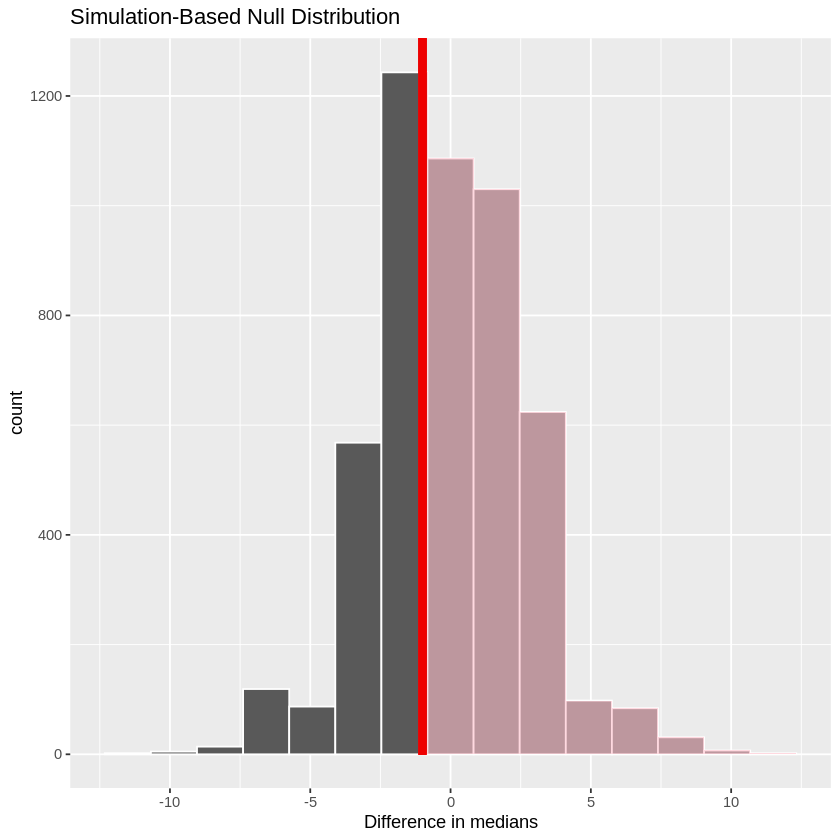

In [57]:
#trees_result_plot <- 
#    null_model_trees %>%
#    visualize() + 
#    shade_p_value(obs_stat = ..., direction = ...)

### BEGIN SOLUTION
trees_result_plot <- 
    null_model_trees %>%
    visualize() + 
    shade_p_value(obs_stat = obs_med_diam_diff, direction = "right") +
    xlab("Difference in medians")
### END SOLUTION

trees_result_plot

In [58]:
test_3.6()

[1] "Success!"


**Question 3.7**
<br>{points: 3}

Obtain the p-value from `null_model_trees`.

_Assign your answer to an object called `answer3.7`_.

In [59]:
#answer3.7 <- 

### BEGIN SOLUTION
answer3.7 <- 
    null_model_trees %>% 
    get_p_value(obs_stat = obs_med_diam_diff, direction = "right")
### END SOLUTION

answer3.7

p_value
<dbl>
0.637


In [60]:
test_3.7()

[1] "Success!"


**Question 3.8**
<br>{points: 3}

What decision should be made at 10% significance level?

A. Reject $H_0$ and commit the Type I Error;

B. Reject $H_0$ and commit the Type 2 Error;

C. Correctly reject $H_0$;

D. Not reject $H_0$ and commit the Type 1 Error;

E. Not reject $H_0$ and commit the Type 2 Error;

F. Correctly not reject $H_0$;

_Assign your answer to an object called `answer3.5`_

In [61]:
#answer3.8 <- 

### BEGIN SOLUTION
answer3.8 <- "E"
### END SOLUTION

answer3.8

[1] "E"

In [62]:
test_3.8()

[1] "Success!"


## 4. Simulation: Exploring the power of a test

In this section, we will simulate data to illustrate two concepts related to hypothesis test. 


Suppose that we are trying to test if the level of albumin in patients with fibrosis is 44g/L (which is the mean albumin level of patients with healthy liver): 

$H_0: \mu = 44g/L$ vs $H_1:\mu < 44g/L$. 

Let's assume that the true mean of patients with Fibrosis is 41.76. Therefore, we know that the alternative hypothesis $H_1$ is the true one. Let's simulate a population now. 

In [63]:
set.seed(1)
# Run this cell before continuing
true_pop <- 
    tibble(albumin = rnorm(50000, 41.76, 3.74))

head(true_pop)

albumin
<dbl>
39.41706
42.44683
38.63475
47.72635
42.99236
38.69145


**Question 4.1**
<br>{points: 3}

Fill in the code below to plot the histogram of the true population.

_Assign your answer to an object called `true_pop_hist`._

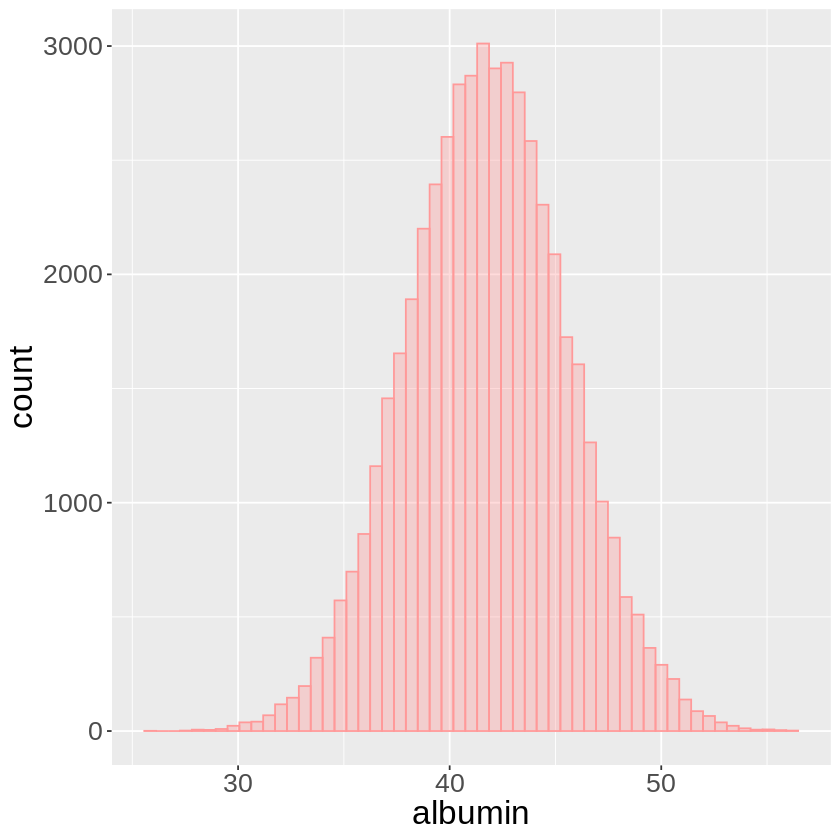

In [64]:

#true_pop_hist <- 
#    true_pop %>% 
#    ....() +
#    ...(..., color="#FF9999", fill="#FF9999", alpha=.35, bins=55)+
#    theme(text = element_text(size=20))

### BEGIN SOLUTION
true_pop_hist <- 
    true_pop %>% 
    ggplot() +
    geom_histogram(aes(albumin), color="#FF9999", fill="#FF9999", alpha=.35, bins=55)+
    theme(text = element_text(size=20))
### END SOLUTION

true_pop_hist

In [65]:
test_4.1()

[1] "Success!"


**Question 4.2**
<br>{points: 3}

To test the hypothesis, we start by taking a sample (from the true population) and calculating the test statistic. In this exercise, you are going to use `rep_sample_n` to take one sample of size 30. 

_Assign your answer to an object called `sample`._

In [66]:
set.seed(1) # Do not change this.

#sample <- 
#    true_pop %>% 
#    ...(... = 30)

### BEGIN SOLUTION
sample <- 
    true_pop %>% 
    rep_sample_n(size = 30)
### END SOLUTION

head(sample)

replicate,albumin
<int>,<dbl>
1,38.34774
1,49.50687
1,38.05065
1,41.54900
1,47.07603
1,34.33513


In [67]:
test_4.2()

[1] "Success!"


**Question 4.3**
<br>{points: 6}

Before we obtain the sampling distribution assuming $H_0$ was true (i.e., the null model), let's study the actual sampling distribution. Generate 10,000 values from the bootstrap sampling distribution and plot its histogram. 

_Assign the generated values to a tibble object called `sampling_dist` and the histogram to an object called `boot_sampl_dist_hist`._

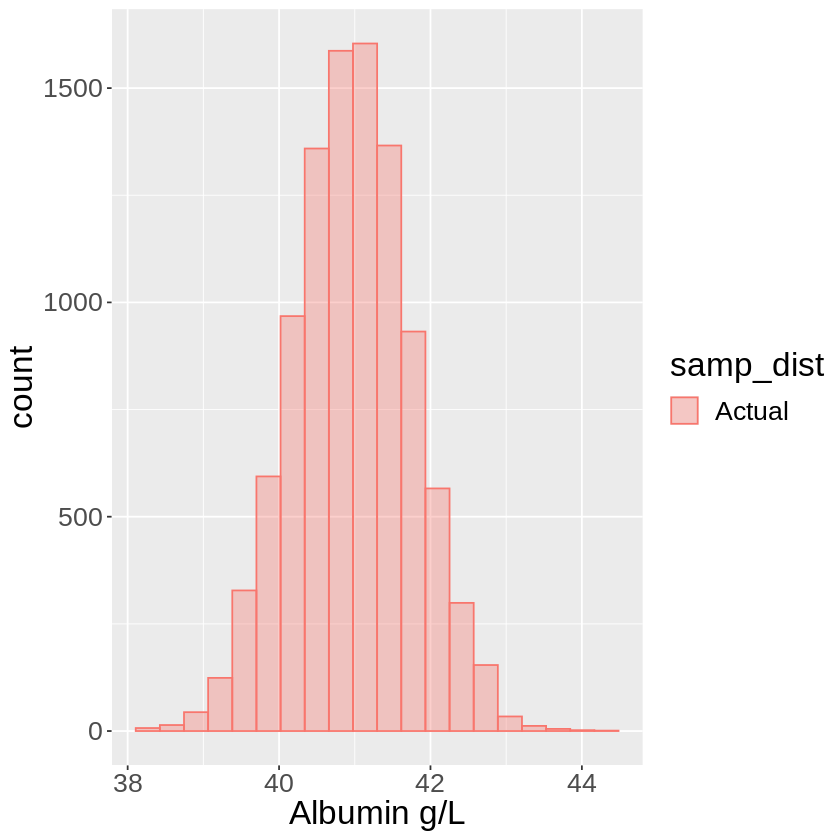

In [68]:
set.seed(1)

#sampling_dist <- 
#    sample %>% 
#    specify(...) %>% 
#    generate(...) %>% 
#    ...(stat = "mean") %>% 
#    mutate(samp_dist = "True")

#boot_sampl_dist_hist <- 
#    sampling_dist %>% 
#    ggplot() +
#    geom_histogram(aes(..., color=samp_dist, fill=samp_dist), alpha=.35, bins=20) +
#    theme(text = element_text(size=20)) + 
#    xlab("Albumin g/L")

### BEGIN SOLUTION
sampling_dist <- 
    sample %>% 
    specify(response = albumin) %>% 
    generate(reps = 10000, type = "bootstrap") %>% 
    calculate(stat = "mean") %>% 
    mutate(samp_dist = "Actual")

boot_sampl_dist_hist <- 
    sampling_dist %>% 
    ggplot() +
    geom_histogram(aes(stat, color=samp_dist, fill=samp_dist), alpha=.35, bins=20) +
    theme(text = element_text(size=20)) + 
    xlab("Albumin g/L")
### END SOLUTION

boot_sampl_dist_hist

In [69]:
test_4.3A()

[1] "Success!"


In [70]:
test_4.3B()

[1] "Success!"


**Question 4.4**
<br>{points: 4}

Next, it is time to conduct the hypothesis test. In this exercise, you need to generate values from the sampling distribution under $H_0$ (i.e., from the null model). 

_Assign the test statistic to an object called `obs_test_stat_4.4` and ensure these values are in a tibble named `null_model_4.4`._

In [71]:
set.seed(1) # Do not change this.

#obs_test_stat_4.4 <- ....

#null_model_4.4 <-
#    sample %>% 
#    specify(...) %>% 
#    ...(...) %>% 
#    generate(reps = 10000, type = "bootstrap") %>% 
#    calculate(...) %>% 
#    mutate(samp_dist = "null model")

### BEGIN SOLUTION
obs_test_stat_4.4 <- mean(sample$albumin)

null_model_4.4 <-
    sample %>% 
    specify(response = albumin) %>% 
    hypothesise(null = "point", mu = 44) %>% 
    generate(reps = 10000, type = "bootstrap") %>% 
    calculate(stat = "mean") %>% 
    mutate(samp_dist = "null model")
### END SOLUTION

obs_test_stat_4.4
head(null_model_4.4)

[1] 40.97224

replicate,stat,samp_dist
<int>,<dbl>,<chr>
1,44.71797,null model
2,43.15822,null model
3,43.66680,null model
4,43.73072,null model
5,44.29037,null model
6,43.42879,null model


In [72]:
test_4.4A()

[1] "Success!"


In [73]:
test_4.4B()

[1] "Success!"


**Question 4.5**
<br>{points: 1}

What type of error are we subject to commit in this hypothesis test?

A. Type I Error

B. Type II Error


_Assign your answer to an object called `answer4.5`. Your answer should be a single character surrounded by quotes._

In [74]:
#answer4.5 <- 
### BEGIN SOLUTION
answer4.5 <- "b"
### END SOLUTION

answer4.5

[1] "b"

In [75]:
test_4.5()

[1] "Success!"


**Question 4.6**
<br>{points: 1}

To understand how type II error can occur, contrast the null model and the actual sampling distribution shown below:

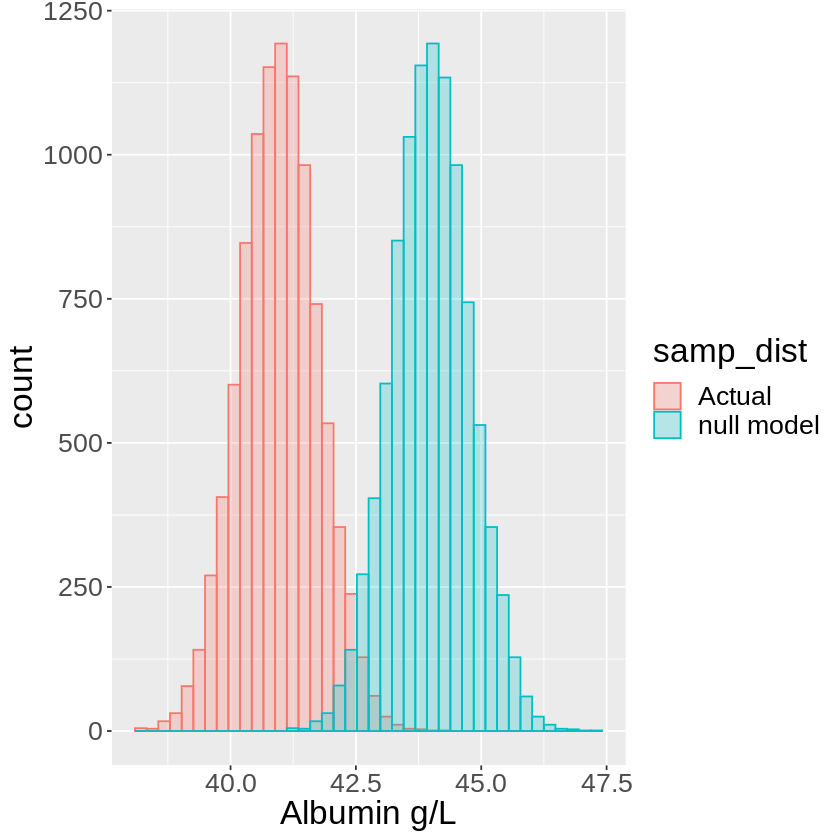

In [76]:
sampling_dist %>% 
    bind_rows(null_model_4.4) %>% 
    ggplot() + 
    geom_histogram(aes(stat, color=samp_dist, fill=samp_dist), alpha=.25, bins=40, position="identity" ) +
    theme(text = element_text(size=20)) + 
    xlab("Albumin g/L")

As you can notice from the image above, there is an overlap between the null model and the actual sampling distribution. The bigger this overlap is, the higher is the chance that the actual sampling distribution generates a test statistic in the region of non-rejection of $H_0$ (imagine moving the red distribution towards the right). Unfortunately, for a given sample size, we cannot reduce the probability of type II error without increasing the probability of type I error. 

There are mainly two things that affect the probability of type II error: (1) the effect size (i.e., the difference between the true parameter and the hypothesized value in $H_0$); and (2) the sample size. 

We say that a test is powerful if it has a high chance of detecting when $H_0$ is false. In this sense, the power of a test is one minus the probability of type II error. 

The question for you here is: 
> Why increasing the sample size also increases the power of a test?

A. Because it increases the effect size by moving the true sampling distribution and the null model in opposing directions, which reduces their overlap. 

B. Because increasing the sample size makes the sampling distribution narrower, reducing the overlap between the true sampling distribution and the null model. 

To help you answer this question, see the plot below. 

_Assign your answer to an object called answer4.6_

In [77]:
set.seed(15)  # Don't worry about this code. You can safely ignore it. 

example <-
    tibble(effect_size = c(1,5,9)) %>% 
    mutate(pop = map(effect_size, ~rnorm(2000, 44-.x, 3))) %>% 
    crossing(tibble(n = c(40, 80, 500))) %>% 
    mutate(samp = map2(pop, n, ~tibble(var=sample(.x, size = .y)))) %>%
    select(-pop) %>% 
    mutate(observed_test_stat = map_dbl(samp, ~mean(.x$var))) %>% 
    mutate(null_model = map(samp,
                            ~specify(.x, response=var) %>% 
                            hypothesise(null = "point", mu = 44) %>% 
                            generate(reps = 10000, type='bootstrap') %>% 
                            calculate(stat = "mean") %>% 
                            mutate(samp_dist = "Null Model")),
           samp_dist_temp = map(samp,
                            ~specify(.x, response=var) %>% 
                            generate(reps = 10000, type='bootstrap') %>% 
                            calculate(stat = "mean") %>% 
                            mutate(samp_dist = "Actual"))) %>% 
    mutate(samp_dist = map2(null_model, samp_dist_temp, ~bind_rows(.x,.y))) %>% 
    select(-null_model, -samp_dist_temp, -samp) %>% 
    unnest(samp_dist) 

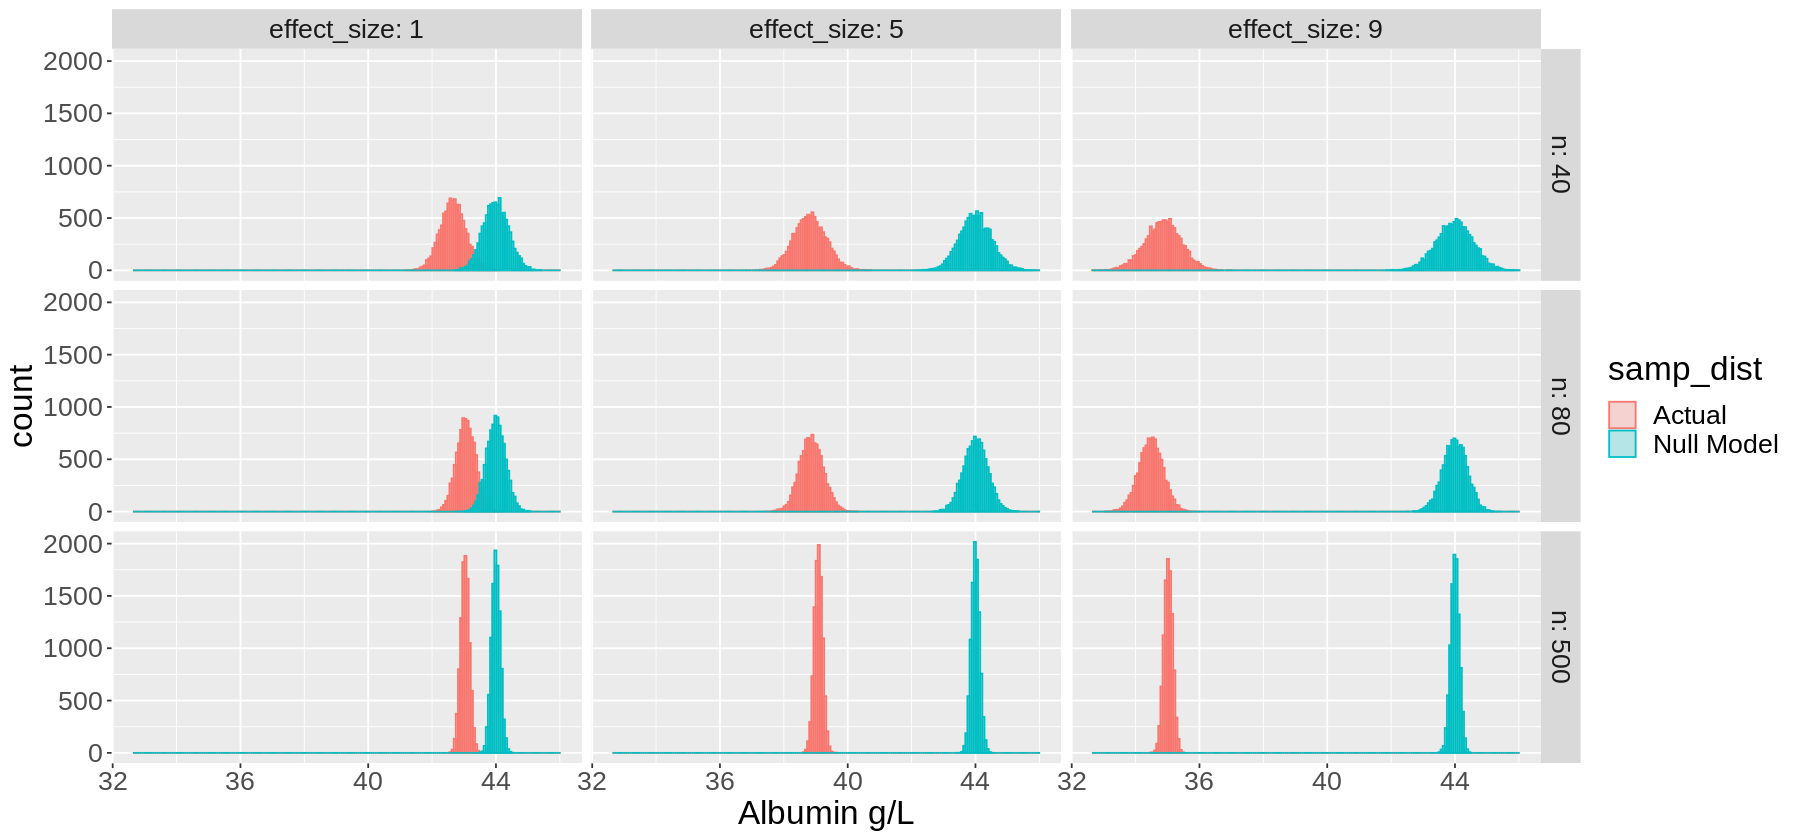

In [78]:
options(repr.plot.width=15, repr.plot.height=7) # Adjust these number so the plot looks good in your desktop

example %>% 
    ggplot() +    
    geom_histogram(aes(stat, color=samp_dist, fill=samp_dist), alpha=.25, bins=200, position="identity" ) +
    facet_grid(n~effect_size, labeller = labeller(.rows = label_both, .cols = label_both))+
    theme(text = element_text(size=20)) + 
    xlab("Albumin g/L")

In [79]:
#answer4.6 <-

### BEGIN SOLUTION
answer4.6 <- "B"
### END SOLUTION

answer4.6

[1] "B"

In [80]:
test_4.6()

[1] "Success!"
